In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm

import os
scores_df = pd.read_parquet(os.path.expanduser('~/smolmodels/data/scored_sorted_logprobs.parquet'))
scores_df.describe()

,loss,reward_accuracy,reward_margin,chosen_rewards,rejected_rewards,chosen_logps,rejected_logps,mean_chosen_logits,mean_rejected_logits
count,54825.000000,54825.0,54825.0,54825.0,54825.0,54825.000000,54825.000000,54825.000000,54825.000000
mean,0.693359,0.0,0.0,0.0,0.0,-349.923684,-293.267055,0.624996,0.551284
std,0.000000,0.0,0.0,0.0,0.0,297.360411,246.629413,0.636891,0.657809
min,0.693359,0.0,0.0,0.0,0.0,-3080.000000,-3712.000000,-2.855469,-2.929688
25%,0.693359,0.0,0.0,0.0,0.0,-518.000000,-405.750000,0.248413,0.171875
50%,0.693359,0.0,0.0,0.0,0.0,-279.500000,-238.125000,0.667480,0.605957
75%,0.693359,0.0,0.0,0.0,0.0,-112.437500,-109.812500,1.046875,0.991211
max,0.693359,0.0,0.0,0.0,0.0,-2.718750,-4.472656,3.835938,3.466797


array([[<Axes: title={'center': 'chosen_logps'}>,
        <Axes: title={'center': 'rejected_logps'}>],
       [<Axes: title={'center': 'mean_chosen_logits'}>,
        <Axes: title={'center': 'mean_rejected_logits'}>],
       [<Axes: title={'center': 'logprobs_diff'}>,
        <Axes: title={'center': 'logits_diff'}>]], dtype=object)

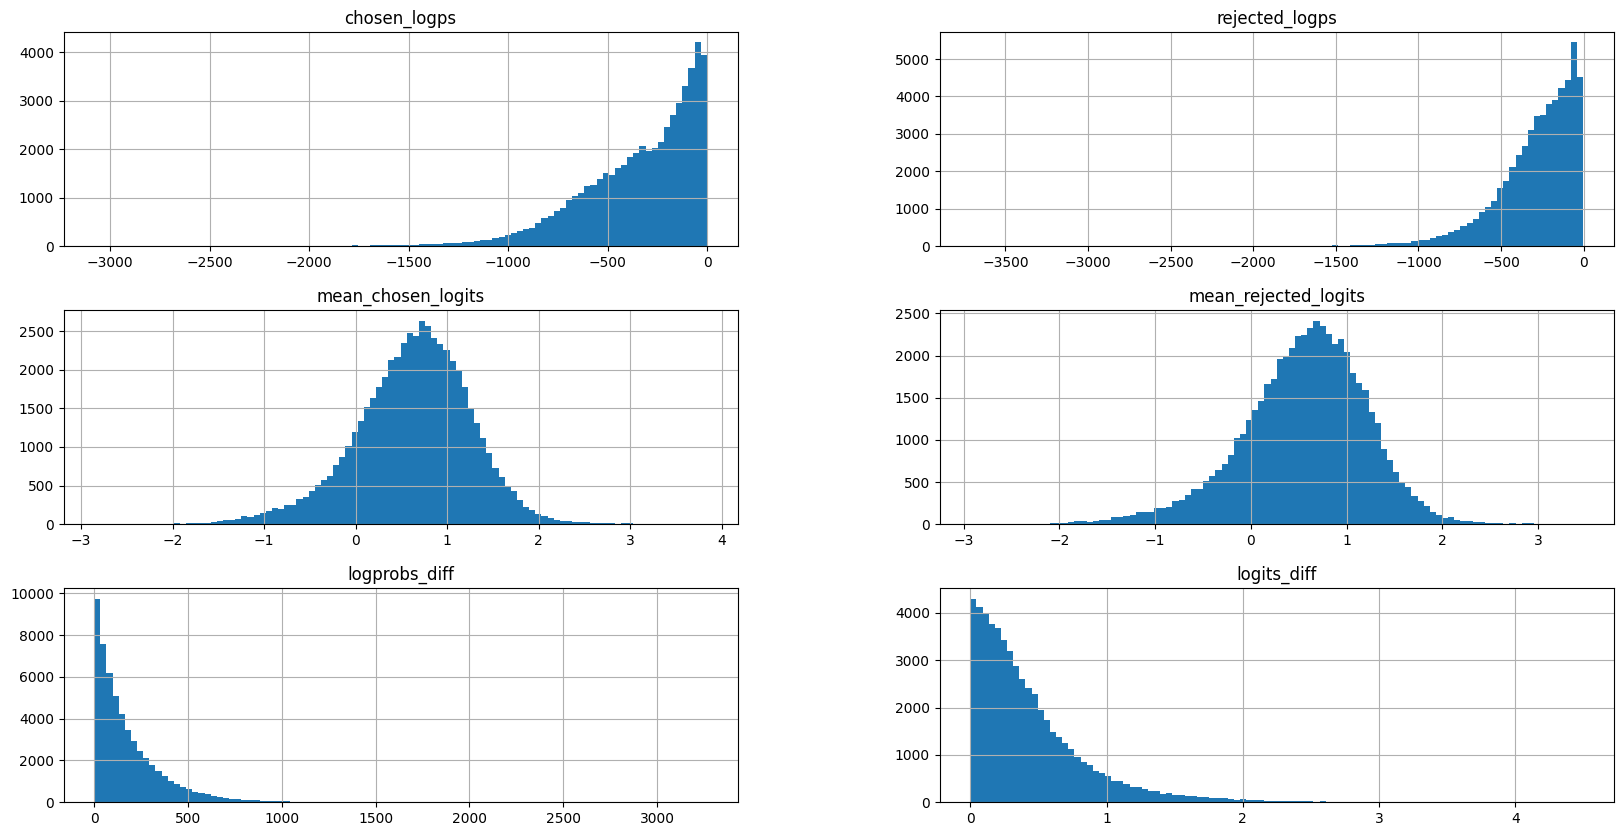

In [83]:
scores_df = scores_df[
    [
        "chosen_logps",
        "rejected_logps",
        "mean_chosen_logits",
        "mean_rejected_logits",
    ]
]
scores_df['logprobs_diff'] = abs(scores_df['chosen_logps'] - scores_df['rejected_logps'])
scores_df['logits_diff'] = abs(scores_df['mean_chosen_logits'] - scores_df['mean_rejected_logits'])
scores_df.hist(bins=100, figsize=(20, 10))

Shapiro-Wilk score: 0.7663217100066406, p-value: 7.548804628157612e-122
logprobs_diff mean: 184.08578648683311, std: 199.26995586673104
logprobs_diff 10th, 50th, 90th percentiles: [-71.28893742 184.08578649 439.46051039          inf]
Shapiro-Wilk score: 0.8233305534749402, p-value: 4.688614652022148e-114
logits_diff mean: 0.44733065471875305, std: 0.422764059841311
logits_diff 10th, 50th, 90th percentiles: [-0.09446329  0.44733065  0.9891246          inf]


/Users/brian/smolmodels/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54825.
  res = hypotest_fun_out(*samples, **kwds)
/Users/brian/smolmodels/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54825.
  res = hypotest_fun_out(*samples, **kwds)


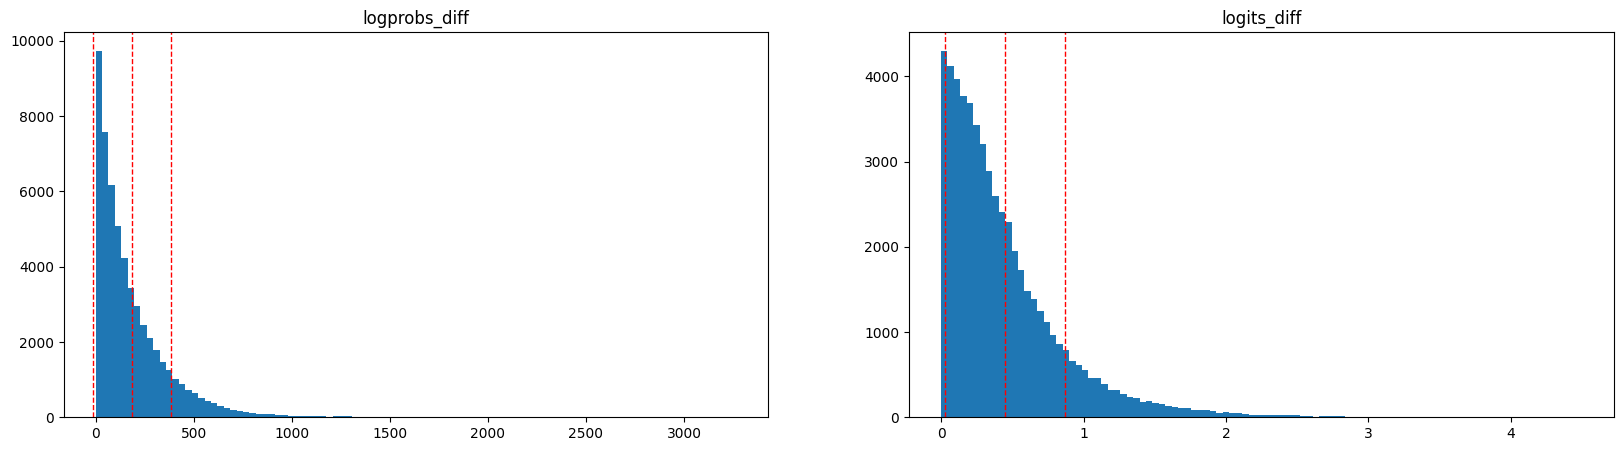

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, col in enumerate(["logprobs_diff", "logits_diff"]):
    mean, std = scores_df[col].mean(), scores_df[col].std()
    stat, p = shapiro(scores_df[col])
    print(f"Shapiro-Wilk score: {stat}, p-value: {p}")
    print(f"{col} mean: {mean}, std: {std}")
    pdf_bins = [10, 50, 90, 100]
    pdf_labels = ['10-50', '50-90', '90-100']
    percentile_bins = norm.ppf([x/100 for x in pdf_bins], loc=mean, scale=std)
    print(f"{col} 10th, 50th, 90th percentiles: {percentile_bins}")
    scores_df[f"{col}_percentile_idx"] = pd.cut(scores_df[col], bins=percentile_bins, labels=pdf_labels, include_lowest=True, right=True)
    axs[i].hist(scores_df[col], bins=100)
    axs[i].axvline(mean, color='r', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean + std, color='r', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean - std, color='r', linestyle='dashed', linewidth=1)
    axs[i].set_title(col)

<Axes: >

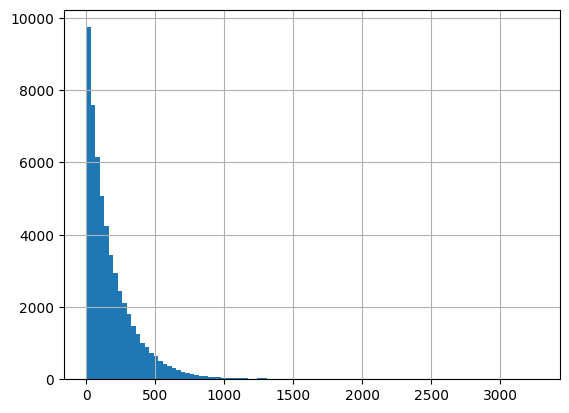

In [85]:
scores_df.logprobs_diff.hist(bins=100)

logprobs_diff 10th, 50th, 90th percentiles: [-71.28893742 184.08578649 439.46051039          inf]


Text(0.5, 1.0, 'Histogram of per-sample logprob distances')

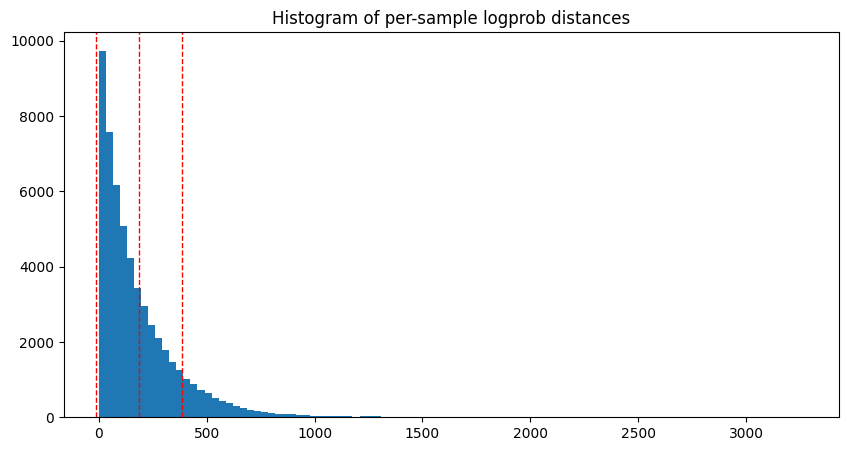

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

col = "logprobs_diff"
mean, std = scores_df[col].mean(), scores_df[col].std()
pdf_bins = [10, 50, 90, 100]
pdf_labels = ['10-50', '50-90', '90-100']
percentile_bins = norm.ppf([x/100 for x in pdf_bins], loc=mean, scale=std)
print(f"{col} 10th, 50th, 90th percentiles: {percentile_bins}")
scores_df[f"{col}_percentile_idx"] = pd.cut(scores_df[col], bins=percentile_bins, labels=pdf_labels, include_lowest=True, right=True) # type: ignore
ax.hist(scores_df[col], bins=100)
ax.axvline(mean, color='r', linestyle='dashed', linewidth=1)
ax.axvline(mean + std, color='r', linestyle='dashed', linewidth=1)
ax.axvline(mean - std, color='r', linestyle='dashed', linewidth=1)
ax.set_title("Histogram of per-sample logprob distances")

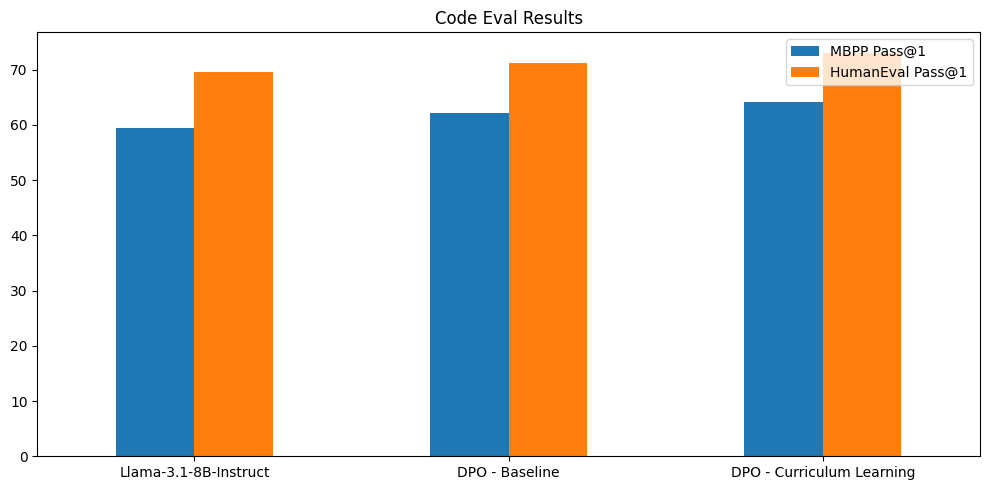

In [88]:
import pandas as pd

MBPP = "MBPP Pass@1"
HUMANEVAL = "HumanEval Pass@1"

eval_results = [
    {"name": "Llama-3.1-8B-Instruct", MBPP: 59.5, HUMANEVAL: 69.5},
    {"name": "DPO - Baseline", MBPP: 62.1, HUMANEVAL: 71.2},
    {"name": "DPO - Curriculum Learning", MBPP: 64.2, HUMANEVAL: 73.1},
]

eval_results_df = pd.DataFrame(eval_results)

ax = eval_results_df.plot.bar(
    x="name", y=[MBPP, HUMANEVAL], figsize=(10, 5), title="Code Eval Results"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("")
plt.tight_layout()


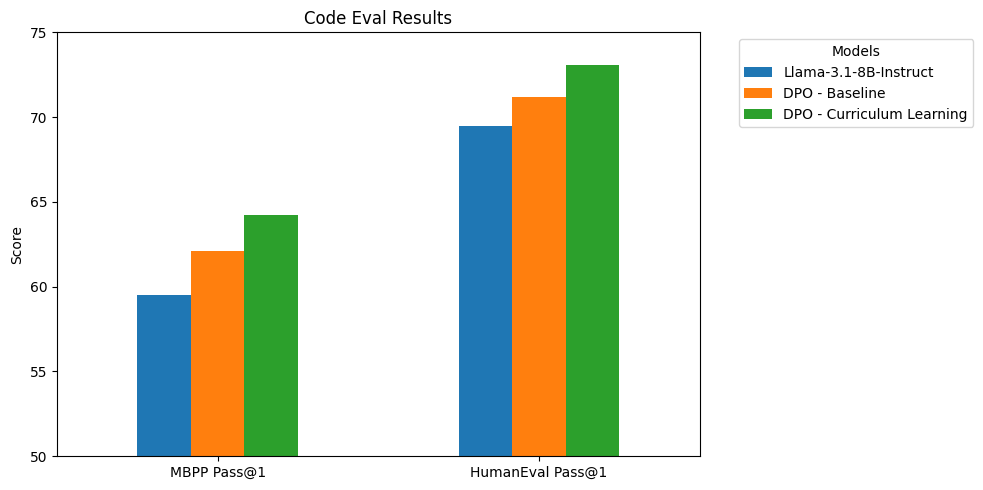

In [68]:
eval_results_df_inverted = eval_results_df.copy()
eval_results_df_inverted.set_index("name", inplace=True)
eval_results_df_inverted = eval_results_df_inverted.T
ax = eval_results_df_inverted.plot(kind="bar", figsize=(10, 5), title="Code Eval Results")

ax.set_ylim(50, 75)
# Customize the plot
plt.xticks(rotation=0)  # Keep group labels horizontal
plt.ylabel("Score")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [129]:
from IPython.display import display, Markdown
sampled_codecontests_df = pd.read_parquet("../data/codecontests_dpo.parquet")
sampled_codecontests_df['logprobs_diff'] = abs(sampled_codecontests_df['chosen_logps'] - sampled_codecontests_df['rejected_logps'])
sampled_codecontests_df['logits_diff'] = abs(sampled_codecontests_df['mean_chosen_logits'] - sampled_codecontests_df['mean_rejected_logits'])
sampled_codecontests_df.sort_values('logprobs_diff', ascending=False, inplace=True)
for i, sample in sampled_codecontests_df.tail(5).iterrows():
    print(sample['logprobs_diff'])
    display(Markdown(f"### Sample {i}"))
    display(Markdown(f"```python\n{sample['chosen']}\n```"))
    display(Markdown(f"```python\n{sample['rejected']}\n```"))

0.1875


### Sample 1026

```python
def max_beauty_journey(n, beauties):
    dp = [0] * n
    dp[0] = beauties[0]
    
    for i in range(1, n):
        dp[i] = beauties[i]
        for j in range(i):
            if i - j == beauties[i] - beauties[j]:
                dp[i] = max(dp[i], dp[j] + beauties[i])
    
    return max(dp)

# Read input
n = int(input())
beauties = list(map(int, input().split()))

# Get the result
result = max_beauty_journey(n, beauties)
print(result)
```

```python
def max_beauty_journey(n, beauties):
    dp = [0] * n
    dp[0] = beauties[0]
    
    for i in range(1, n):
        dp[i] = beauties[i]
        for j in range(i):
            if i - j == beauties[i] - beauties[j]:
                dp[i] = max(dp[i], dp[j] + beauties[i])
    
    return max(dp)

# Example usage
n1 = 6
beauties1 = [10, 7, 1, 9, 10, 15]
print(max_beauty_journey(n1, beauties1))  # Output: 26

n2 = 1
beauties2 = [400000]
print(max_beauty_journey(n2, beauties2))  # Output: 400000

n3 = 7
beauties3 = [8, 9, 26, 11, 12, 29, 14]
print(max_beauty_journey(n3, beauties3))  # Output: 55
```

0.1875


### Sample 277

```python
def minimum_city_area(n, mines):
    min_x = min(mine[0] for mine in mines)
    max_x = max(mine[0] for mine in mines)
    min_y = min(mine[1] for mine in mines)
    max_y = max(mine[1] for mine in mines)

    side_length = max(max_x - min_x, max_y - min_y)
    area = side_length ** 2
    return area

# Example usage
n = int(input())
mines = [tuple(map(int, input().split())) for _ in range(n)]
print(minimum_city_area(n, mines))
```

```python
def minimum_city_area(n, mines):
    min_x = min(x for x, y in mines)
    max_x = max(x for x, y in mines)
    min_y = min(y for x, y in mines)
    max_y = max(y for x, y in mines)
    
    side_length = max(max_x - min_x, max_y - min_y)
    return side_length ** 2

# Example usage
n1 = 2
mines1 = [(0, 0), (2, 2)]
print(minimum_city_area(n1, mines1))  # Output: 4

n2 = 2
mines2 = [(0, 0), (0, 3)]
print(minimum_city_area(n2, mines2))  # Output: 9
```

0.125


### Sample 384

```python
def find_sequence(n, a, b):
    t = [0] * n
    
    for t1 in range(4):
        t[0] = t1
        valid = True
        
        for i in range(1, n):
            t2_found = False
            for t2 in range(4):
                if (t[0] | t2 == a[i-1]) and (t[0] & t2 == b[i-1]):
                    t[i] = t2
                    t2_found = True
                    break
            
            if not t2_found:
                valid = False
                break
            
            t[0] = t[i]  # Move to the next pair
        
        if valid:
            return "YES", t
    
    return "NO", []

# Input reading
n = int(input())
a = list(map(int, input().split()))
b = list(map(int, input().split()))

# Function call and output
result = find_sequence(n, a, b)
if result[0] == "NO":
    print(result[0])
else:
    print(result[0])
    print(" ".join(map(str, result[1])))
```

```python
def find_sequence(n, a, b):
    t = [0] * n
    
    for t1 in range(4):
        t[0] = t1
        valid = True
        
        for i in range(n - 1):
            t2_found = False
            for t2 in range(4):
                if (t[0] | t2 == a[i]) and (t[0] & t2 == b[i]):
                    t[1] = t2
                    t2_found = True
                    break
            
            if not t2_found:
                valid = False
                break
            
            if i < n - 2:
                t[0] = t[1]
        
        if valid:
            for i in range(1, n - 1):
                t2_found = False
                for t2 in range(4):
                    if (t[i] | t2 == a[i]) and (t[i] & t2 == b[i]):
                        t[i + 1] = t2
                        t2_found = True
                        break
                
                if not t2_found:
                    valid = False
                    break
            
            if valid:
                print("YES")
                print(" ".join(map(str, t)))
                return
    
    print("NO")

# Example usage
n = 4
a = [3, 3, 2]
b = [1, 2, 0]
find_sequence(n, a, b)

n = 3
a = [1, 3]
b = [3, 2]
find_sequence(n, a, b)
```

0.0625


### Sample 197

```python
def can_sort_friends(test_cases):
    results = []
    for n, a in test_cases:
        if sorted(a) == a or sorted(a) == a[::-1]:
            results.append("YES")
        else:
            results.append("NO")
    return results

# Read input
t = int(input())
test_cases = []
for _ in range(t):
    n = int(input())
    a = list(map(int, input().split()))
    test_cases.append((n, a))

# Get results
results = can_sort_friends(test_cases)

# Print output
for result in results:
    print(result)
```

```python
def can_sort_friends(test_cases):
    results = []
    for n, a in test_cases:
        sorted_a = sorted(a)
        if all(a[i] <= sorted_a[i] for i in range(n)):
            results.append("YES")
        else:
            results.append("NO")
    return results

# Read input
t = int(input())
test_cases = []
for _ in range(t):
    n = int(input())
    a = list(map(int, input().split()))
    test_cases.append((n, a))

# Get results
results = can_sort_friends(test_cases)

# Print output
for result in results:
    print(result)
```

0.0625


### Sample 300

```python
def can_sort_friends(test_cases):
    results = []
    for n, a in test_cases:
        if sorted(a) == a or sorted(a) == a[::-1]:
            results.append("YES")
        else:
            results.append("NO")
    return results

# Read input
t = int(input())
test_cases = []
for _ in range(t):
    n = int(input())
    a = list(map(int, input().split()))
    test_cases.append((n, a))

# Get results
results = can_sort_friends(test_cases)

# Print output
for result in results:
    print(result)
```

```python
def can_sort_friends(test_cases):
    results = []
    for n, a in test_cases:
        sorted_a = sorted(a)
        if all(a[i] <= sorted_a[i] for i in range(n)):
            results.append("YES")
        else:
            results.append("NO")
    return results

# Read input
t = int(input())
test_cases = []
for _ in range(t):
    n = int(input())
    a = list(map(int, input().split()))
    test_cases.append((n, a))

# Get results
results = can_sort_friends(test_cases)

# Print output
for result in results:
    print(result)
```